In [1031]:
import pandas as pd
import numpy as np
import os
import openpyxl
import matplotlib.pyplot as plt
from time import sleep

In [1032]:
#Base de otimização de rotas

otimizacao_rotas = pd.read_excel("Otimização de rotas.xlsx",sheet_name='Trajeto Geral (Equ x Base Faz)', skiprows=6).drop(['Unnamed: 0','Unnamed: 1'],axis=1)

In [1033]:
#Capacidade por equipe
capacidade_equipe = pd.read_excel("cadastro equipes e demandas.xlsx", sheet_name='Capacidade por equipe')

In [1034]:
#Base de demandas

demanda = pd.read_excel('cadastro equipes e demandas.xlsx', sheet_name='Demanda por fazenda', dtype={'ID Fazenda': 'object', 'Mês de Demanda': 'datetime64[ns]'})

In [1035]:
#Função de máscara

def mascara(df, coluna,n_digitos):
    df[coluna] = df[coluna].astype(str)
    df[coluna] = str("000") + df[coluna]
    df[coluna] = df[coluna].astype(str).str[-n_digitos:] 
    return df

In [1036]:
#demanda 
demanda = mascara(demanda,'ID Fazenda', 4)

demanda.sample(3)#tail(3)#.head(5)

,ID Fazenda,Fazenda,Área Avaliada,Mês avaliação,Data de Avaliação
97,0131,SÃO GERALDO,8.34,2024-04-01,2024-04-05
312,0368,J-UMEDA II,177.63,2024-04-01,2024-04-14
369,0427,SÃO CRISTÓVÃO II,74.92,2024-04-01,2024-04-10


In [1037]:
#Data frame de equipes e siglas
equipes = [ i for  i in otimizacao_rotas['COD'].str[7:].unique()]
equipes_s = [ i for  i in otimizacao_rotas['Equipe'].unique()]


equipes_base = pd.DataFrame(
    { 'Equipe': equipes,
     'Equipe sigla' : equipes_s
    }
)

equipes_base.head(len(equipes))

,Equipe,Equipe sigla
0,Lençóis Paulista,A
1,Duartina,B
2,Garça,C
3,Pirajuí,D
4,Bauru,E
5,Getulina,G
6,Cabrália Paulista,H


In [1038]:
#Capacidade da equipe 

capacidade_equipe['Gordura'] = 0.05

capacidade_equipe['Capacidade ajustada'] = (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade']) + capacidade_equipe['Capacidade']

#capacidade_equipe['Capacidade minima'] = capacidade_equipe['Capacidade'] - (capacidade_equipe['Gordura'] * capacidade_equipe['Capacidade'])


capacidade_equipe = capacidade_equipe.merge(equipes_base, on='Equipe', how='left')

capacidade_equipe.head(6)

,Equipe,Capacidade,Distancia,Mês Operacional,Gordura,Capacidade ajustada,Equipe sigla
0,Lençóis Paulista,7400,5000,2024-04-01,0.05,7770.0,A
1,Duartina,7400,5000,2024-04-01,0.05,7770.0,B
2,Garça,7400,5000,2024-04-01,0.05,7770.0,C
3,Pirajuí,7400,5000,2024-04-01,0.05,7770.0,D
4,Bauru,7400,5000,2024-04-01,0.05,7770.0,E
5,Getulina,7400,5000,2024-04-01,0.05,7770.0,G


In [1039]:
#Otimização de rotas

otimizacao_rotas = mascara(otimizacao_rotas,'ID Fazenda',4)

otimizacao_rotas

,Equipe,Cidade origem,ID Fazenda,Projeto,Área,COD,Trajeto (Km)
0,A,Lençóis Paulista,0001,MAMEDINA,1772.63,0001 - Lençóis Paulista,15.396001
1,B,Duartina,0001,MAMEDINA,1772.63,0001 - Duartina,79.279400
2,C,Garça,0001,MAMEDINA,1772.63,0001 - Garça,110.671138
3,D,Pirajuí,0001,MAMEDINA,1772.63,0001 - Pirajuí,91.583666
4,E,Bauru,0001,MAMEDINA,1772.63,0001 - Bauru,36.688475
...,...,...,...,...,...,...,...
6617,C,Garça,2417,CAFEZAL,120.82,2417 - Garça,252.471501
6618,D,Pirajuí,2417,CAFEZAL,120.82,2417 - Pirajuí,262.590625
6619,E,Bauru,2417,CAFEZAL,120.82,2417 - Bauru,207.695434
6620,G,Getulina,2417,CAFEZAL,120.82,2417 - Getulina,312.662195


In [1040]:
#Construindo otimização de rotas

#trazendo base de demandas
otimizacao_rotas = otimizacao_rotas.merge(demanda[['ID Fazenda','Área Avaliada', 'Mês avaliação']], left_on='ID Fazenda', right_on='ID Fazenda', how='left')

#Ordenando a base
otimizacao_rotas = otimizacao_rotas.sort_values(['Mês avaliação','ID Fazenda','Trajeto (Km)'],ascending=[True,True,True])

#Capacidade por equipe
otimizacao_rotas = otimizacao_rotas.merge(capacidade_equipe[['Mês Operacional', 'Capacidade', 'Capacidade ajustada', 'Equipe sigla']],left_on=['Equipe','Mês avaliação'], right_on=['Equipe sigla','Mês Operacional'], how='left')

otimizacao_rotas= otimizacao_rotas.rename({
    'Mês Operacional':'Mês operacional equipe',
    'Mês avaliação': 'Mês demanda'
}, axis=1)


otimizacao_rotas = otimizacao_rotas.drop(['Equipe sigla','Cidade origem'],axis=1)


otimizacao_rotas = otimizacao_rotas[pd.notna(otimizacao_rotas['Mês operacional equipe'])]


In [1041]:
#Resetando o índice para utilizá-lo no i.loc
otimizacao_rotas.reset_index(drop=True, inplace=True)

otimizacao_rotas['Equipe mais próxima'] = 0
ordem = 0

for i in range(1, len(otimizacao_rotas)):
    if otimizacao_rotas.loc[i, 'ID Fazenda'] == otimizacao_rotas.loc[i-1, 'ID Fazenda']:
        ordem += 1
    else:
        ordem = 0
    otimizacao_rotas.loc[i, 'Equipe mais próxima'] = ordem

In [1042]:
#Criar um print para ir rodando quais são as equipes mais próximas e qual a distância. Pode ser um dicionário. mas deve ser printado para mostrar a funcionalidade da ferramenta

In [1043]:
#Criar uma lógica para criar um dicionário que vai aumentando a demanda conforme é atribuído fazendas para ela de acordo com a coluna equipe mais próxima

#A fazenda deve sempre ser atribuída no momento que ela for mais próxima da equipe, a capacidade só pode ser olhada quando a equipe mais próxima for maior que zero

#Tabelinha de demanda da equipe com a demanda mês atual dela


In [1044]:
#Analisar capacidade

demanda_total_mes = demanda.groupby(['Mês avaliação'])['Área Avaliada'].sum().reset_index()

capacidade_total_mes = capacidade_equipe.groupby(['Mês Operacional'])['Capacidade ajustada'].sum().reset_index()

analise_capacidade = demanda_total_mes.merge(capacidade_total_mes, left_on='Mês avaliação', right_on='Mês Operacional', how='left')

analise_capacidade['delta capacidade'] = analise_capacidade['Capacidade ajustada'] - analise_capacidade['Área Avaliada']   

analise_capacidade['status capacidade'] = np.where(analise_capacidade['delta capacidade'] > 0 , 'temos Capacidade para a demanda', 'não temos capacidade para a demanda')

analise_capacidade['Mês avaliação'] = analise_capacidade['Mês avaliação'].dt.strftime('%m-%y')

for k,v in analise_capacidade.iterrows():
    print(f"No mês {v['Mês avaliação']} {v['status capacidade']}")


analise_capacidade


No mês 03-24 não temos capacidade para a demanda
No mês 04-24 não temos capacidade para a demanda


,Mês avaliação,Área Avaliada,Mês Operacional,Capacidade ajustada,delta capacidade,status capacidade
0,03-24,85794.63,2024-03-01,54390.0,-31404.63,não temos capacidade para a demanda
1,04-24,71352.96,2024-04-01,54390.0,-16962.96,não temos capacidade para a demanda


In [1045]:
#Plano A

#Sempre vai me trazer qual é a equipe mais próxima

def definir_equipe(row,proximidade):
    if (row['Equipe mais próxima'] == proximidade ) & (row['Mês demanda'] == row['Mês operacional equipe']):
        return row['Equipe']
    else:
        return np.nan

otimizacao_rotas['Plano A'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(0,))

otimizacao_rotas['Plano B'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(1,))

otimizacao_rotas['Plano C'] = otimizacao_rotas.apply(definir_equipe,axis=1,args=(2,))


#O ffill preenche todas as linhas até embaixo, fazendo com que todas as linhas da mesma fazenda sejam preenchidas até então

otimizacao_rotas.to_excel('analise.xlsx')


In [1046]:
#Agora com o plano A definido, vamos criar uma base para ir somando a demanda da equipe por programação

#Limitador de quilometragem 

#A Equipe pode andar quantos quilometros por mês? 
#Do mesmo jeito que tenho capacidade máxima, devo ter distância máxima para percorrer



carteira_equipe = {}


def adiciona_equipe(informacoes_equipe, dicionario, demanda_inicial, km_inicial):
    for _, v in informacoes_equipe.iterrows():
        dicionario[v['Equipe sigla'] + v['Mês Operacional'].strftime('%m-%y')] = {
            'equipe': v['Equipe sigla'],
            'mes': pd.to_datetime(v['Mês Operacional']),
            'demanda': demanda_inicial,
            'capacidade maxima': v['Capacidade ajustada'],
            'distancia maxima' : v['Distancia'],#
            #'capacidade minima': v['Capacidade minima']
            'km': km_inicial
        }

# Adicionar equipes ao dicionário
adiciona_equipe(capacidade_equipe, carteira_equipe, 0,0)


In [1047]:
carteira_df = pd.DataFrame.from_dict(carteira_equipe,orient='index')


In [1048]:
#Construir função para ir aumentando a carteira de áreas da equipe


def credito_demanda(carteira_df,banco_areas):

    banco_areas['equipe atribuída'] = ''
    banco_areas['equipe atribuída att'] = ''
    banco_areas['equipe atribuída2'] = ''
    banco_areas['equipe atribuída att2'] = ''
    banco_areas['equipe atribuída3'] = ''
    banco_areas['equipe atribuída att3'] = ''



    def pegar_primeiro_nao_vazio(series):
        return series[series != ' '].iloc[0] if (series != 'Sem capacidade').any() else 'Sem capacidade'


    for chave_banco, valor_banco in banco_areas.iterrows():

    
        for chave_carteira, valor_carteira in carteira_df.items():

            #Ao invez de definir o plano A, posso utilizar o idxmin() e pegar o mínimo para o plano, e caso a equipe não tenha mais capacidade pode ser que ele não entre na demanda
                #Tentar evoluir na ideia, pode ser a solução para os problemas futuros
           
            if (valor_carteira['equipe'] == valor_banco['Plano A']) and (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):
      
                
            #Define a equipe para a equipe mais próxima que é o Plano A
                if  ((valor_banco['Área Avaliada'] + valor_carteira['demanda']) < valor_carteira['capacidade maxima']) and \
                ((valor_banco['Trajeto (Km)'] + valor_carteira['km']) < valor_carteira['distancia maxima']):
                    
                    #Atribuir a fazenda para a equipe
                    banco_areas.loc[chave_banco,'equipe atribuída'] = valor_carteira['equipe']
                   
                   #Somar demandas de área e km
                    valor_carteira['demanda'] += valor_banco['Área Avaliada']
                    valor_carteira['km'] += valor_banco['Trajeto (Km)']

                    print(f"demanda adicionada de {valor_banco['Área Avaliada']:.2f} para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda adicionada é {valor_banco['ID Fazenda']}")
            
               
            #Definir a equipe para o plano B no momento em que a soma da área avaliada mais a demanda é menor que a capacidade máxima da carteira
                else:

                    #Definindo quais são as fazendas que não temos capacidade para as equipes 
                    banco_areas.loc[chave_banco,'equipe atribuída'] = 'Sem capacidade'


                    print(f"Fazenda não adicionada, falta capacidade para a equipe {valor_carteira['equipe']}")
                    print(f"fazenda não adicionada é {valor_banco['ID Fazenda']}")

# # Atualizar a coluna 'equipe atribuída att' após o primeiro loop
    banco_areas['equipe atribuída att'] = banco_areas.groupby('ID Fazenda')['equipe atribuída'].transform('first')
        
#     #Encontrando tudo que deve ser plano B


    for chave_banco, valor_banco in banco_areas.iterrows():

        if valor_banco['equipe atribuída att'] == 'Sem capacidade':             
            
            for chave_carteira, valor_carteira in carteira_df.items():    


                if (valor_carteira['equipe'] == valor_banco['Plano B']) and \
                 (valor_banco['equipe atribuída att'] == 'Sem capacidade') and \
                 (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):
                    
                    if (((valor_banco['Área Avaliada'] + valor_carteira['demanda'])) < valor_carteira['capacidade maxima']) and \
                     ((valor_banco['Trajeto (Km)'] + valor_carteira['km']) < valor_carteira['distancia maxima']):
                                                                      
                        banco_areas.loc[chave_banco,'equipe atribuída2'] = valor_carteira['equipe']
                        
                        valor_carteira['demanda'] += valor_banco['Área Avaliada']
                        valor_carteira['km'] += valor_banco['Trajeto (Km)']

    

                    print('iterando novamente na base para os talhões sem capacidade - Definindo de acordo ao plano B')
                   

            else:
                banco_areas.loc[chave_banco,'equipe atribuída'] = 'Sem capacidade'
                print('Não necessário iterar - Plano B')


    #Atualizar a coluna de equipe atribuída para trazer a informação correta
    banco_areas['equipe atribuída att2'] = banco_areas.groupby('ID Fazenda')['equipe atribuída2'].transform(lambda x: x.iloc[1] if len(x) > 1 else None)

    #Atualizando a coluna de equipe atribuída para poder utilizá-la novamente
    banco_areas['equipe atribuída att'] = np.where((banco_areas['equipe atribuída att'] == 'Sem capacidade') & 
                                               (pd.notna(banco_areas['equipe atribuída att2'])) & 
                                               (banco_areas['equipe atribuída att2'] != ''), 
                                               banco_areas['equipe atribuída att2'],
                                               banco_areas['equipe atribuída att'])
  
      

#     #Encontrando tudo o que deve ser plano C
    for chave_banco, valor_banco in banco_areas.iterrows():
        
         if valor_banco['equipe atribuída att'] == 'Sem capacidade':
            for chave_carteira, valor_carteira in carteira_df.items():

                if (valor_carteira['equipe'] == valor_banco['Plano B']) and \
                (valor_banco['equipe atribuída att'] == 'Sem capacidade') and \
                (pd.to_datetime(valor_carteira['mes']) == pd.to_datetime(valor_banco['Mês demanda'])):

                    if (((valor_banco['Área Avaliada'] + valor_carteira['demanda'])) < valor_carteira['capacidade maxima']) and \
                    ((valor_banco['Trajeto (Km)'] + valor_carteira['km']) < valor_carteira['distancia maxima']):

                        banco_areas.loc[chave_banco,'equipe atribuída att3'] = valor_carteira['equipe']

                        valor_carteira['demanda'] += valor_banco['Área Avaliada']
                        valor_carteira['km'] += valor_banco['Trajeto (Km)']
                    
                        print('iterando novamente na base para os talhões sem capacidade - Definindo de acordo ao plano C')

                    else:
                        banco_areas.loc[chave_banco,'equipe atribuída'] = 'Sem capacidade'
    
                else:   
    
                    print('Não necessário iterar - Plano C')

    banco_areas['equipe atribuída att3'] = banco_areas.groupby('ID Fazenda')['equipe atribuída3'].transform(lambda x: x.iloc[2] if len(x) > 1 else None)

    banco_areas['equipe atribuída att'] = np.where((banco_areas['equipe atribuída att'] == 'Sem capacidade') & 
                                               (pd.notna(banco_areas['equipe atribuída att3'])) & 
                                               (banco_areas['equipe atribuída att3'] != ''), 
                                               banco_areas['equipe atribuída att3'],
                                               banco_areas['equipe atribuída att'])


#         #sleep(1)
            

In [1049]:
credito_demanda(carteira_equipe,otimizacao_rotas)

demanda adicionada de 748.94 para a equipe H
fazenda adicionada é 0003
demanda adicionada de 820.61 para a equipe D
fazenda adicionada é 0006
demanda adicionada de 404.91 para a equipe A
fazenda adicionada é 0010
demanda adicionada de 12.36 para a equipe A
fazenda adicionada é 0016
demanda adicionada de 144.01 para a equipe D
fazenda adicionada é 0024
demanda adicionada de 168.63 para a equipe B
fazenda adicionada é 0029
demanda adicionada de 373.19 para a equipe E
fazenda adicionada é 0030
demanda adicionada de 864.02 para a equipe A
fazenda adicionada é 0035
demanda adicionada de 141.83 para a equipe A
fazenda adicionada é 0048
demanda adicionada de 62.21 para a equipe A
fazenda adicionada é 0049
demanda adicionada de 692.38 para a equipe E
fazenda adicionada é 0057
demanda adicionada de 71.38 para a equipe E
fazenda adicionada é 0058
demanda adicionada de 55.12 para a equipe B
fazenda adicionada é 0061
demanda adicionada de 112.64 para a equipe E
fazenda adicionada é 0074
demanda ad

In [1050]:
#Data frame do dicionário e seguindo a orientação por index

carteira_df = pd.DataFrame.from_dict(carteira_equipe, orient='index')


#Realizar filtro para ver apenas a data escolhida

filtro_data = pd.Timestamp(day=1, month=4, year=2024 )

carteira_df = carteira_df[carteira_df['mes'] ==filtro_data ]

carteira_df

,equipe,mes,demanda,capacidade maxima,distancia maxima,km
A04-24,A,2024-04-01,7756.27,7770.0,5000,1710.170594
B04-24,B,2024-04-01,7769.28,7770.0,5000,930.883547
C04-24,C,2024-04-01,7768.44,7770.0,5000,1162.613434
D04-24,D,2024-04-01,7755.56,7770.0,5000,1068.898359
E04-24,E,2024-04-01,7767.10,7770.0,5000,1154.550697
G04-24,G,2024-04-01,7616.09,7770.0,5000,1990.795393
H04-24,H,2024-04-01,7752.35,7770.0,5000,1345.186637


In [1051]:
filtro_data = pd.Timestamp(day=1, month=3, year=2024)

distribuicao = atribuindo_equipe.drop_duplicates(subset='ID Fazenda', keep='first').groupby(['equipe atribuída att','Mês demanda'])[['Área Avaliada', 'Trajeto (Km)']].sum().reset_index()


distribuicao = distribuicao[distribuicao['Mês demanda'] == filtro_data]



In [1057]:
distribuicao

,equipe atribuída att,Mês demanda,Área Avaliada,Trajeto (Km)
0,A,2024-03-01,7767.02,4462.710665
2,B,2024-03-01,7594.46,1375.774575
4,C,2024-03-01,7726.71,1252.377074
6,D,2024-03-01,7600.99,839.797136
8,E,2024-03-01,7759.16,2150.296561
10,G,2024-03-01,7764.25,556.814788
12,H,2024-03-01,7755.47,658.770724
14,Sem capacidade,2024-03-01,31826.57,15127.165831


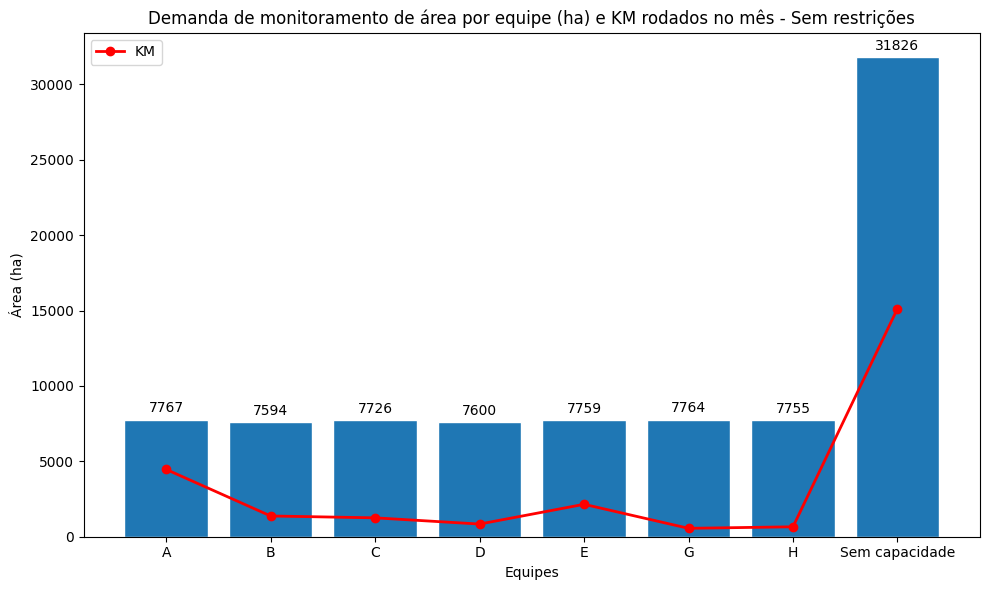

In [1053]:
fig_srest, ax = plt.subplots(figsize=(10, 6))  # Largura de 10 polegadas e altura de 6 polegadas

# Dados do gráfico de barras
xbar = distribuicao['equipe atribuída att']
ybar = distribuicao['Área Avaliada']

# Dados do gráfico de linhas
xline = distribuicao['equipe atribuída att']
yline = distribuicao['Trajeto (Km)']

# Criar o gráfico de barras
bars = ax.bar(xbar, ybar, width=0.8, edgecolor='white')

# Adicionar rótulos às barras
ax.bar_label(bars, fmt='%d', padding=3)

# Criar o gráfico de linhas no mesmo conjunto de eixos
ax.plot(xline, yline, color='red', marker='o', linestyle='-', linewidth=2, label='KM')

ax.legend()

ax.set_xlabel('Equipes')

ax.set_ylabel('Área (ha)')

ax.set_title('Demanda de monitoramento de área por equipe (ha) e KM rodados no mês - Sem restrições') 

fig_srest.tight_layout()

plt.show()

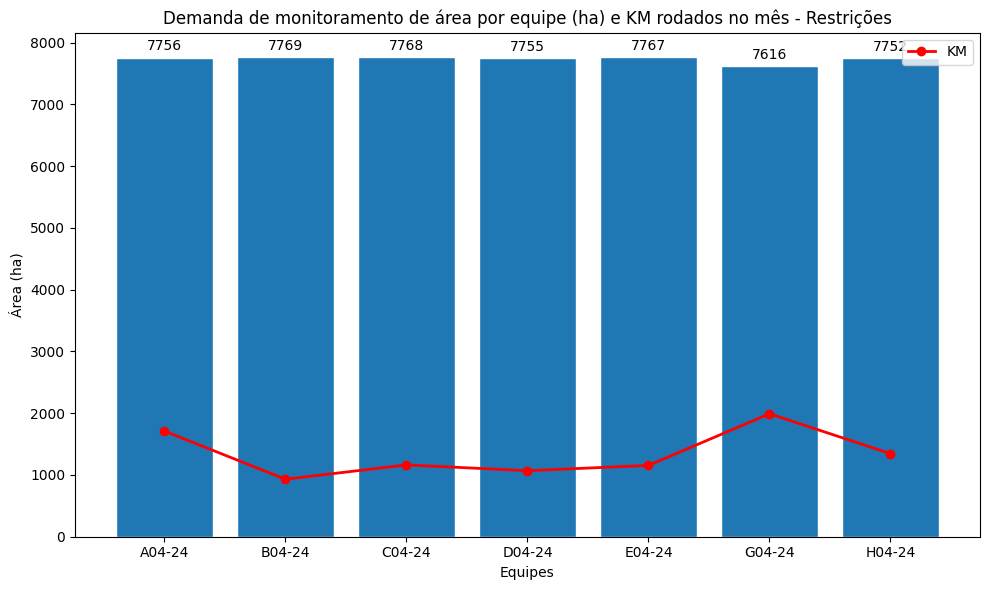

In [1054]:
fig, ax = plt.subplots(figsize=(10, 6))  # Largura de 10 polegadas e altura de 6 polegadas

# Dados do gráfico de barras
xbar = carteira_df.index
ybar = carteira_df['demanda']

# Dados do gráfico de linhas
xline = carteira_df.index
yline = carteira_df['km']

# Criar o gráfico de barras
bars = ax.bar(xbar, ybar, width=0.8, edgecolor='white')

# Adicionar rótulos às barras
ax.bar_label(bars, fmt='%d', padding=3)

# Criar o gráfico de linhas no mesmo conjunto de eixos
ax.plot(xline, yline, color='red', marker='o', linestyle='-', linewidth=2, label='KM')

ax.legend()

ax.set_xlabel('Equipes')

ax.set_ylabel('Área (ha)')

ax.set_title('Demanda de monitoramento de área por equipe (ha) e KM rodados no mês - Restrições')

fig.tight_layout()

plt.show()
